<a href="https://colab.research.google.com/github/Max-FM/seagrass/blob/master/notebooks/prepare_training_data_banc_d_arguin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing Banc d'Arguin imaging to create seagrass training data for machine learning

##Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Install `seagrass` package

In [2]:
%%capture

!pip install git+https://github.com/Max-FM/seagrass.git

##Create mosaic from Sentinel 2 images and import projected seagrass data

In [3]:
from seagrass.raster import open_and_match_rasters

In [4]:
#  Scenes of interest are numbers 7, 8, 11, 12 & 13, particulary 11 and 12.
s2_filepath = '/content/drive/MyDrive/Bathymetry/BancDarguin_s2cldmdn_000012.tif'
seagrass_filepath = '/content/drive/Shareddrives/1_Satellite_Derived_Bathymetry & coastal veg/Banc dArguin bathymetry & seagrass/seagrass_geotiff/seagrass_combined.tif'

In [5]:
s2, seagrass = open_and_match_rasters(s2_filepath, seagrass_filepath)

##Trim down rasters

In [6]:
s2 = s2[:, 3000:, :]
seagrass = seagrass[:, 3000:, :]

##Plot mosaic and seagrass images

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np

In [8]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

def make_s2_rgb(s2_raster):
    red = s2_raster[5]
    green = s2_raster[4]
    blue = s2_raster[3]

    return make_composite(red, green, blue)

(2567, 5011, 3)

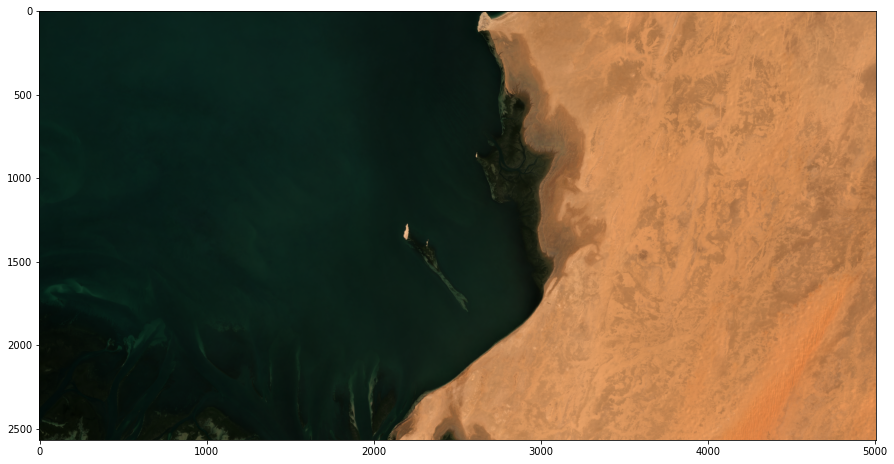

In [9]:
rgb = make_s2_rgb(s2)

plt.figure(figsize=(15,15))
plt.imshow(rgb)

rgb.shape

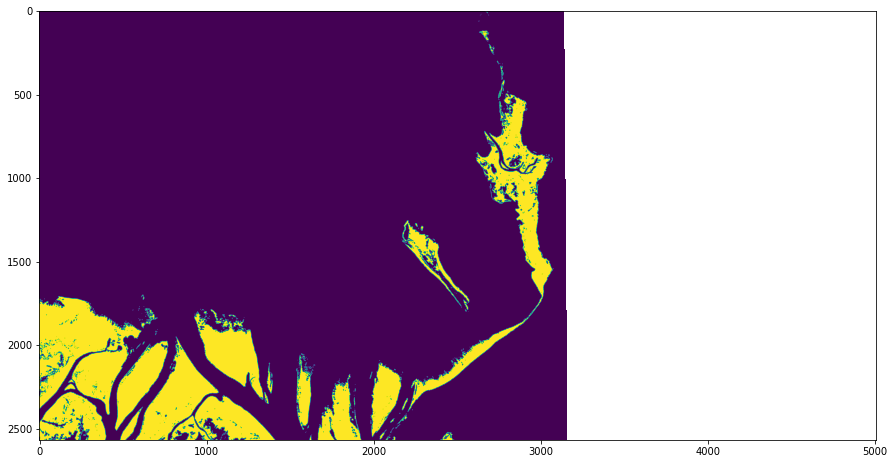

In [10]:
plt.figure(figsize=(15,15))
show(seagrass.where(seagrass!=-9999))

##Define features and targets for machine learning

In [11]:
from seagrass.prepare import create_training_data
from seagrass.utils import save_training_data

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [12]:
%%time

X, y = create_training_data(s2.values, seagrass.values, no_data_value=-9999, s2_bands=[3,4,5,6,7,8,9])

CPU times: user 4.07 s, sys: 3.06 s, total: 7.12 s
Wall time: 7.33 s


In [13]:
display(X, y)
display(X.shape, y.shape)

array([[0.0866    , 0.09855   , 0.05156667, ..., 0.03769099, 0.03798243,
        0.03603234],
       [0.08736667, 0.0965    , 0.05075   , ..., 0.03771506, 0.03800215,
        0.03604416],
       [0.0886    , 0.09615   , 0.0515    , ..., 0.037753  , 0.03802817,
        0.03608549],
       ...,
       [0.2348    , 0.34813333, 0.4864    , ..., 0.54295234, 0.55819482,
        0.5703334 ],
       [0.2377    , 0.35064   , 0.4892    , ..., 0.54275053, 0.55783612,
        0.56956188],
       [0.2372    , 0.3493    , 0.48746667, ..., 0.5422583 , 0.55721199,
        0.56849727]])

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

(8110823, 14)

(8110823, 1)

##Save training data to Modulos compatible tar file

In [14]:
# training_dir = '/content/drive/Shareddrives/1_Satellite_Derived_Bathymetry & coastal veg/Banc dArguin bathymetry & seagrass/seagrass_training_data'
training_dir = '.'

# Optional column header labels.
cols = ['b', 'g', 'r', 're1', 're2', 're3', 'nir', 'b_g', 'g_g', 'r_g', 're1_g', 're2_g', 're3_g', 'nir_g', 'seagrass']

In [15]:
save_training_data(f'{training_dir}/banc_d_arguin_seagrass_train.tar', X, y, column_labels=cols)